# Robotics II - the Jetbot track follower

### <u>Authors:</u>
- Maria Musiał : 156062
- Joanna Szczublińska : 156070
- Wiktoria Szarzyńska : 156058

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

### Defining dataset class

In [2]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]

class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            # Five-class one-hot encoding
            if left < -0.5:
                class_idx = 0
            elif left < -0.25:
                class_idx = 1
            elif left <= 0.25:
                class_idx = 2
            elif left <= 0.5:
                class_idx = 3
            else:
                class_idx = 4

            forward_tensor = torch.tensor(forward, dtype=torch.float32)
            left_tensor = torch.tensor(class_idx, dtype=torch.long)

            return image, (forward_tensor, left_tensor)


            # return image, torch.tensor([forward, left], dtype=torch.float32)
        

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
def get_transforms(augument=True):
    """Create transformations for training and validation"""
    common_transforms = [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    # augmentation
    if augument:
        # Transformations: resize to 224x224, color jitter, normalize for rgb values predefined using imagenet 
        train_transforms = [
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),  #color transofmrations
            transforms.RandomRotation(10),
            *common_transforms
        ]  
        return transforms.Compose(train_transforms)
    else:
        return transforms.Compose(common_transforms)

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_samples_per_folder(dataset):
    folder_counts = defaultdict(int)
    for img_path, _, _ in dataset.samples:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_counts[folder] += 1
    
    folders = list(folder_counts.keys())
    counts = [folder_counts[f] for f in folders]
    
    plt.figure(figsize=(12, 6))
    plt.bar(folders, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Samples per Folder")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()


def show_sample_images(dataset, num=9):
    indices = np.random.choice(len(dataset), num, replace=False)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img, (fwd, left) = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Fwd: {fwd:.2f}, Left: {left:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_target_distributions(dataset):
    forward_vals = [s[1] for s in dataset.samples]
    left_vals = [s[2] for s in dataset.samples]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(forward_vals, bins=50, color='skyblue')
    plt.title("Forward Distribution")
    plt.xlabel("Forward")
    
    plt.subplot(1, 3, 2)
    plt.hist(left_vals, bins=50, color='salmon')
    plt.title("Left Distribution")
    plt.xlabel("Left")

    plt.subplot(1, 3, 3)
    plt.scatter(forward_vals, left_vals, alpha=0.3, s=5)
    plt.title("Forward vs Left")
    plt.xlabel("Forward")
    plt.ylabel("Left")

    plt.tight_layout()
    plt.show()



Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

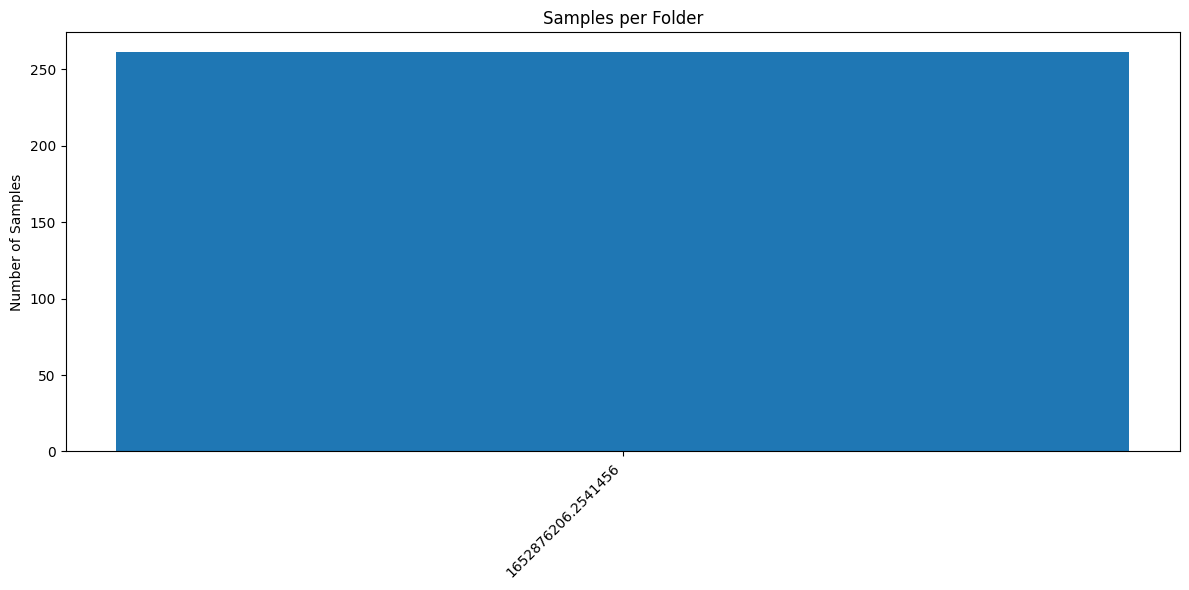

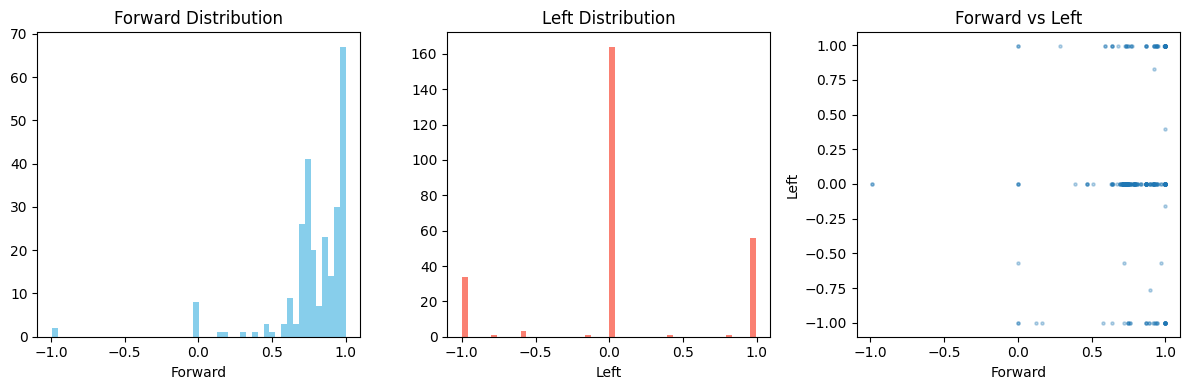

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = JetBotDataset(root_dir="dataset/", transform=transform)

plot_samples_per_folder(train_dataset)
plot_target_distributions(train_dataset)
# show_sample_images(train_dataset, num=6)


### Dividing dataset to train, test, validation

In [5]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Get transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset with dummy transform (we'll override it in subsets)
    full_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(full_dataset)

    # Compute lengths
    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Assign transforms manually (they use the same dataset class)
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = val_test_transform
    test_set.dataset.transform = val_test_transform

    # Optionally return DataLoaders
    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }


## Displaying dataset

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to unnormalize using ImageNet stats
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Show a batch of images from DataLoader
def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    print(len(images))
    print(len(labels))
    # print(labels)
    # Unnormalize all images in the batch
    unnorm_images = unnormalize(images.clone())

    # Create a grid and display
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=5)
    npimg = img_grid.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(npimg)
    plt.axis("off")

    # Show the [forward, left] labels
    print("Labels (forward, left):")
    
    for i in range(min(8, len(images))):  # show up to 5 labels
        print(f"Forward: {labels[0][i]}, Left: {labels[1][i]}")
        # print(f"{i+1}. {labels[i][0]}")

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images[0], labels[0])
# # Example usage (assuming train_loader exists)
# show_batch(train_loader)


In [7]:
data = create_datasets(root_dir = "dataset/", batch_size=8)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]


Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

8
2
Labels (forward, left):
Forward: 0.8046875, Left: 2
Forward: 0.7890625, Left: 2
Forward: 0.8984375, Left: 2
Forward: 1.0, Left: 4
Forward: 0.7890625, Left: 2
Forward: 0.921875, Left: 2
Forward: 0.671875, Left: 2
Forward: 0.7734375, Left: 2


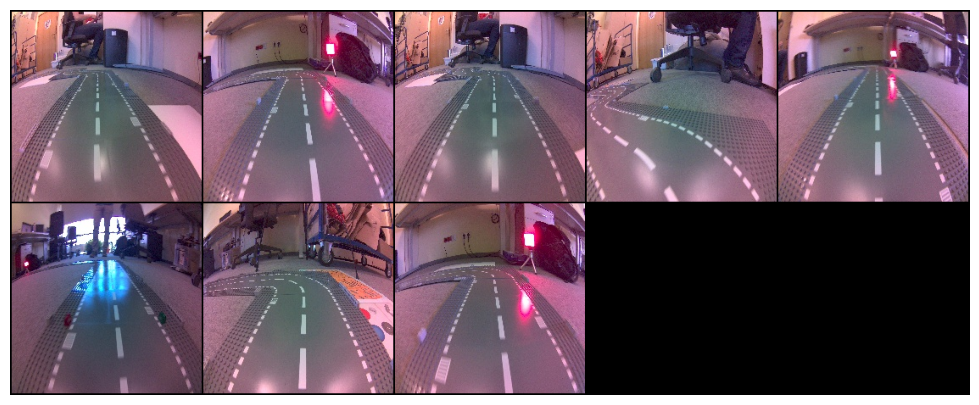

In [8]:
show_batch(train_loader)


###  Nvidia paper CNN


In [9]:
class NvidiaPaperNetwork(nn.Module):
    """implementation of nvidia's end-to-end self driving cars network"""
    def __init__(self):
        super(NvidiaPaperNetwork, self).__init__()
        
        
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # 224 -> 112 -> 56 -> 28 -> 14 -> 14 after all conv layers
        feature_size = 32 *14*14  #32 channels of 28x28
        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        # self.output = nn.Linear(10, 2)  # Output of 2 values: forward, left
        # self.output = nn.Linear(10, 4)  # 1 forward (regression), 3 left logits (classification)
        self.output = nn.Linear(10, 6)  # 1 regression + 5 classification


        
    def forward(self, x):
        
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)  #Flatten the output 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        
        return x
    

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = NvidiaPaperNetwork().to(device)

Using device: cpu


In [11]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
NvidiaPaperNetwork(
  (conv1a): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(12, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2b): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(18, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=6, bias=True)
)

Total parameters: 435,800


In [12]:
class MultiTaskLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression_loss = nn.HuberLoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        pred_forward = predictions[:, 0]  # (B,)
        pred_lefts = predictions[:, 1:]   # (B, 3)

        target_forward, target_lefts = targets  # (B,), (B, 3)

        # Regression loss
        reg_loss = self.regression_loss(pred_forward, target_forward)

        # Classification loss (assumes targets are class indices)
        class_loss = self.classification_loss(pred_lefts, target_lefts)

        return reg_loss + class_loss  # or weighted sum


In [13]:
def training(model, train_loader, val_loader, device, epochs=120):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 25
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    criterion = MultiTaskLoss()

    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            
            forward, left_classes = targets
            forward = forward.to(device)
            left_classes = left_classes.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            

            # Now split outputs: outputs[: , 0] for forward, outputs[:, 1:] for classification
            pred_forward = outputs[:, 0]
            pred_left = outputs[:, 1:]
       
            loss_reg = F.mse_loss(pred_forward, forward)
            loss_cls = F.cross_entropy(pred_left, left_classes)

            loss = loss_reg + loss_cls  # or weighted sum
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                
                forward, left_classes = targets
                forward = forward.to(device)
                left_classes = left_classes.to(device)

                outputs = model(images)

                pred_forward = outputs[:, 0]
                pred_left = outputs[:, 1:]

                loss_reg = F.mse_loss(pred_forward, forward)
                loss_cls = F.cross_entropy(pred_left, left_classes)  # class indices, not one-hot
                
                loss = loss_reg + loss_cls
                val_loss += float(loss)

                val_iterator.set_postfix(loss=float(loss))

                        
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [17]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and visualize predictions.
    """
    model.eval()
    all_targets_forward = []
    all_preds_forward = []

    all_targets_left = []
    all_preds_left = []

    test_loss = 0.0

    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc="Evaluating")

        for images, targets in test_iterator:
            images = images.to(device)
            forward, left_classes = targets
            forward = forward.to(device)
            left_classes = left_classes.to(device)

            outputs = model(images)

            pred_forward = outputs[:, 0]
            pred_logits = outputs[:, 1:]
            pred_class = pred_logits.argmax(dim=1)

            # Convert one-hot to class indices (if needed)
            if left_classes.ndim == 2:
                target_class = left_classes.argmax(dim=1)
            else:
                target_class = left_classes

            # Compute loss
            loss_reg = F.mse_loss(pred_forward, forward)
            loss_cls = F.cross_entropy(pred_logits, target_class)

            loss = loss_reg + loss_cls
            test_loss += float(loss)

            # Save for analysis
            all_preds_forward.extend(pred_forward.cpu().numpy())
            all_targets_forward.extend(forward.cpu().numpy())
            all_preds_left.extend(pred_class.cpu().numpy())
            all_targets_left.extend(target_class.cpu().numpy())

            test_iterator.set_postfix(loss=float(loss))

    test_loss /= len(test_loader)
    print(f"\nFinal test loss: {test_loss:.6f}")

    # Compute metrics
    all_preds_forward = np.array(all_preds_forward)
    all_targets_forward = np.array(all_targets_forward)
    all_preds_left = np.array(all_preds_left)
    all_targets_left = np.array(all_targets_left)

    mae_forward = np.mean(np.abs(all_preds_forward - all_targets_forward))
    acc_left = np.mean(all_preds_left == all_targets_left)

    print(f"Mean Absolute Error (Forward): {mae_forward:.6f}")
    print(f"Classification Accuracy (Left): {acc_left:.4f}")

    # Visualization: Forward
    plt.figure(figsize=(10, 6))
    plt.plot(all_targets_forward, label='True Forward', color='blue')
    plt.plot(all_preds_forward, label='Predicted Forward', color='red', alpha=0.7)
    plt.title("Forward (Regression) Predictions vs Ground Truth")
    plt.xlabel("Sample")
    plt.ylabel("Forward Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualization: Left (5 classes)
    plt.figure(figsize=(10, 6))
    plt.plot(all_targets_left, label='True Left Class', color='blue')
    plt.plot(all_preds_left, label='Predicted Left Class', color='green', alpha=0.7)
    plt.title("Left (Classification) Predictions vs Ground Truth")
    plt.xlabel("Sample")
    plt.ylabel("Left Class Index (0 to 4)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return test_loss, mae_forward, acc_left


Using device: cpu
Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.25414

Epoch 1/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.90it/s, loss=2.55]


Epoch 1/120 - Train loss: 0.000000 - Val loss: 2.527231
New best model saved with val loss: 2.527231


Epoch 2/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=2.19]


Epoch 2/120 - Train loss: 0.000000 - Val loss: 2.168141
New best model saved with val loss: 2.168141


Epoch 3/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=1.81]


Epoch 3/120 - Train loss: 0.000000 - Val loss: 1.779188
New best model saved with val loss: 1.779188


Epoch 4/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=1.67]


Epoch 4/120 - Train loss: 0.000000 - Val loss: 1.632875
New best model saved with val loss: 1.632875


Epoch 5/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 20.01it/s, loss=1.61]


Epoch 5/120 - Train loss: 0.000000 - Val loss: 1.569275
New best model saved with val loss: 1.569275


Epoch 6/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=1.54]


Epoch 6/120 - Train loss: 0.000000 - Val loss: 1.494527
New best model saved with val loss: 1.494527


Epoch 7/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s, loss=1.44]


Epoch 7/120 - Train loss: 0.000000 - Val loss: 1.378883
New best model saved with val loss: 1.378883


Epoch 8/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=1.27]


Epoch 8/120 - Train loss: 0.000000 - Val loss: 1.188237
New best model saved with val loss: 1.188237


Epoch 9/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=1.14]


Epoch 9/120 - Train loss: 0.000000 - Val loss: 1.045008
New best model saved with val loss: 1.045008


Epoch 10/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.86it/s, loss=1.23]


Epoch 10/120 - Train loss: 0.000000 - Val loss: 1.102839


Epoch 11/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s, loss=1.17]


Epoch 11/120 - Train loss: 0.000000 - Val loss: 1.045445


Epoch 12/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.95it/s, loss=1.15]


Epoch 12/120 - Train loss: 0.000000 - Val loss: 1.037741
New best model saved with val loss: 1.037741


Epoch 13/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=1.17]


Epoch 13/120 - Train loss: 0.000000 - Val loss: 1.078698


Epoch 14/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.58it/s, loss=1.19]


Epoch 14/120 - Train loss: 0.000000 - Val loss: 1.085794


Epoch 15/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.46it/s, loss=1.2]


Epoch 15/120 - Train loss: 0.000000 - Val loss: 1.070096


Epoch 16/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=1.1]


Epoch 16/120 - Train loss: 0.000000 - Val loss: 1.020401
New best model saved with val loss: 1.020401


Epoch 17/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 21.18it/s, loss=1.15]


Epoch 17/120 - Train loss: 0.000000 - Val loss: 1.044029


Epoch 18/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 20.08it/s, loss=1.14]


Epoch 18/120 - Train loss: 0.000000 - Val loss: 1.042805


Epoch 19/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.87it/s, loss=1.21]


Epoch 19/120 - Train loss: 0.000000 - Val loss: 1.080120


Epoch 20/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=1.16]


Epoch 20/120 - Train loss: 0.000000 - Val loss: 1.019353
New best model saved with val loss: 1.019353


Epoch 21/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=1.17]


Epoch 21/120 - Train loss: 0.000000 - Val loss: 0.997967
New best model saved with val loss: 0.997967


Epoch 22/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=1.11]


Epoch 22/120 - Train loss: 0.000000 - Val loss: 0.954411
New best model saved with val loss: 0.954411


Epoch 23/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s, loss=1.18]


Epoch 23/120 - Train loss: 0.000000 - Val loss: 0.993645


Epoch 24/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.94it/s, loss=1.1]


Epoch 24/120 - Train loss: 0.000000 - Val loss: 0.936895
New best model saved with val loss: 0.936895


Epoch 25/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=1.1]


Epoch 25/120 - Train loss: 0.000000 - Val loss: 0.956900


Epoch 26/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=1.06]


Epoch 26/120 - Train loss: 0.000000 - Val loss: 0.921745
New best model saved with val loss: 0.921745


Epoch 27/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.51it/s, loss=1.04]


Epoch 27/120 - Train loss: 0.000000 - Val loss: 0.888311
New best model saved with val loss: 0.888311


Epoch 28/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s, loss=1.08]


Epoch 28/120 - Train loss: 0.000000 - Val loss: 0.948057


Epoch 29/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=0.944]


Epoch 29/120 - Train loss: 0.000000 - Val loss: 0.848735
New best model saved with val loss: 0.848735


Epoch 30/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=1.02]


Epoch 30/120 - Train loss: 0.000000 - Val loss: 0.884874


Epoch 31/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=1.05]


Epoch 31/120 - Train loss: 0.000000 - Val loss: 0.888711


Epoch 32/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=1.02]


Epoch 32/120 - Train loss: 0.000000 - Val loss: 0.851697


Epoch 33/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=1.04]


Epoch 33/120 - Train loss: 0.000000 - Val loss: 0.867108


Epoch 34/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=1.01]


Epoch 34/120 - Train loss: 0.000000 - Val loss: 0.847897
New best model saved with val loss: 0.847897


Epoch 35/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.53it/s, loss=1.19]


Epoch 35/120 - Train loss: 0.000000 - Val loss: 0.960966


Epoch 36/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=1.16]


Epoch 36/120 - Train loss: 0.000000 - Val loss: 0.953224


Epoch 37/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s, loss=1.28]


Epoch 37/120 - Train loss: 0.000000 - Val loss: 1.047372


Epoch 38/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=1.04]


Epoch 38/120 - Train loss: 0.000000 - Val loss: 0.878761


Epoch 39/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.18it/s, loss=0.986]


Epoch 39/120 - Train loss: 0.000000 - Val loss: 0.859588


Epoch 40/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.65it/s, loss=1.44]


Epoch 40/120 - Train loss: 0.000000 - Val loss: 1.147912


Epoch 41/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.99it/s, loss=1.14]


Epoch 41/120 - Train loss: 0.000000 - Val loss: 0.921161


Epoch 42/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=1.18]


Epoch 42/120 - Train loss: 0.000000 - Val loss: 0.957972


Epoch 43/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.30it/s, loss=1.12]


Epoch 43/120 - Train loss: 0.000000 - Val loss: 0.883581


Epoch 44/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=1.04]


Epoch 44/120 - Train loss: 0.000000 - Val loss: 0.839227
New best model saved with val loss: 0.839227


Epoch 45/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s, loss=1.15]


Epoch 45/120 - Train loss: 0.000000 - Val loss: 0.901212


Epoch 46/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.25it/s, loss=0.971]


Epoch 46/120 - Train loss: 0.000000 - Val loss: 0.796306
New best model saved with val loss: 0.796306


Epoch 47/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s, loss=1.01]


Epoch 47/120 - Train loss: 0.000000 - Val loss: 0.807407


Epoch 48/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s, loss=1.09]


Epoch 48/120 - Train loss: 0.000000 - Val loss: 0.853227


Epoch 49/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.84it/s, loss=1.14]


Epoch 49/120 - Train loss: 0.000000 - Val loss: 0.861770


Epoch 50/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=1.12]


Epoch 50/120 - Train loss: 0.000000 - Val loss: 0.847032


Epoch 51/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=1.09]


Epoch 51/120 - Train loss: 0.000000 - Val loss: 0.852492


Epoch 52/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s, loss=1.31]


Epoch 52/120 - Train loss: 0.000000 - Val loss: 0.955079


Epoch 53/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.46it/s, loss=1.07]


Epoch 53/120 - Train loss: 0.000000 - Val loss: 0.831512


Epoch 54/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=1.32]


Epoch 54/120 - Train loss: 0.000000 - Val loss: 0.972837


Epoch 55/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s, loss=1.26]


Epoch 55/120 - Train loss: 0.000000 - Val loss: 0.941039


Epoch 56/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=1.25]


Epoch 56/120 - Train loss: 0.000000 - Val loss: 0.909702


Epoch 57/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=1.16]


Epoch 57/120 - Train loss: 0.000000 - Val loss: 0.874982


Epoch 58/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.83it/s, loss=1.19]


Epoch 58/120 - Train loss: 0.000000 - Val loss: 0.873937


Epoch 59/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=1.27]


Epoch 59/120 - Train loss: 0.000000 - Val loss: 0.956664


Epoch 60/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.95it/s, loss=1.26]


Epoch 60/120 - Train loss: 0.000000 - Val loss: 0.957172


Epoch 61/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=1.18]


Epoch 61/120 - Train loss: 0.000000 - Val loss: 0.916455


Epoch 62/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=1.24]


Epoch 62/120 - Train loss: 0.000000 - Val loss: 0.922979


Epoch 63/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.09it/s, loss=1.46]


Epoch 63/120 - Train loss: 0.000000 - Val loss: 1.049134


Epoch 64/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s, loss=1.67]


Epoch 64/120 - Train loss: 0.000000 - Val loss: 1.197212


Epoch 65/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=1.54]


Epoch 65/120 - Train loss: 0.000000 - Val loss: 1.135376


Epoch 66/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=1.5]


Epoch 66/120 - Train loss: 0.000000 - Val loss: 1.121839


Epoch 67/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s, loss=1.5]


Epoch 67/120 - Train loss: 0.000000 - Val loss: 1.071487


Epoch 68/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.46it/s, loss=1.64]


Epoch 68/120 - Train loss: 0.000000 - Val loss: 1.227024


Epoch 69/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.12it/s, loss=1.61]


Epoch 69/120 - Train loss: 0.000000 - Val loss: 1.141360


Epoch 70/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s, loss=1.58]


Epoch 70/120 - Train loss: 0.000000 - Val loss: 1.146586


Epoch 71/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=1.48]


Epoch 71/120 - Train loss: 0.000000 - Val loss: 1.117391
Early stopping triggered at epoch 72.
Training completed. Best val loss: 0.796306


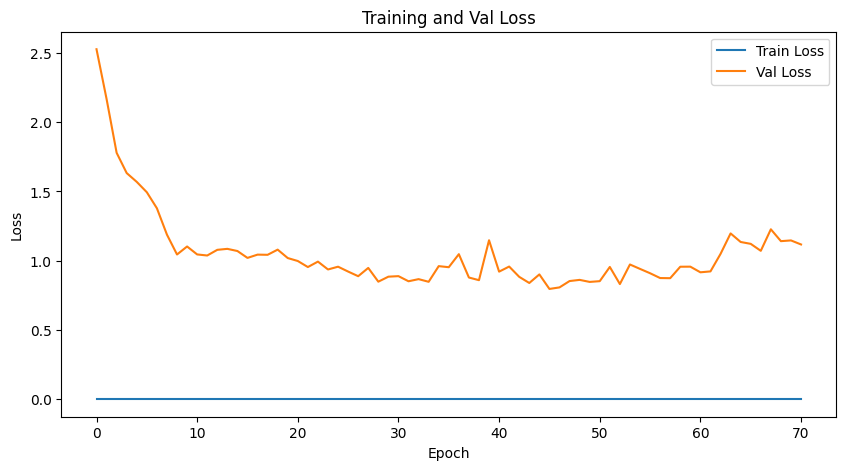

<All keys matched successfully>

In [15]:
# root_dir = "put_jetbot_dataset/dataset/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = create_datasets(root_dir = "dataset/", batch_size=20)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

# Create model and move to device
model = NvidiaPaperNetwork().to(device)

# Print model summary
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Train the model
best_model_path = training(model, train_loader, test_loader, device, epochs=120)

# Load the best model
model.load_state_dict(torch.load(best_model_path))


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, loss=0.971]



Final test loss: 0.796306
Mean Absolute Error (Forward): 0.241725
Classification Accuracy (Left): 0.7500


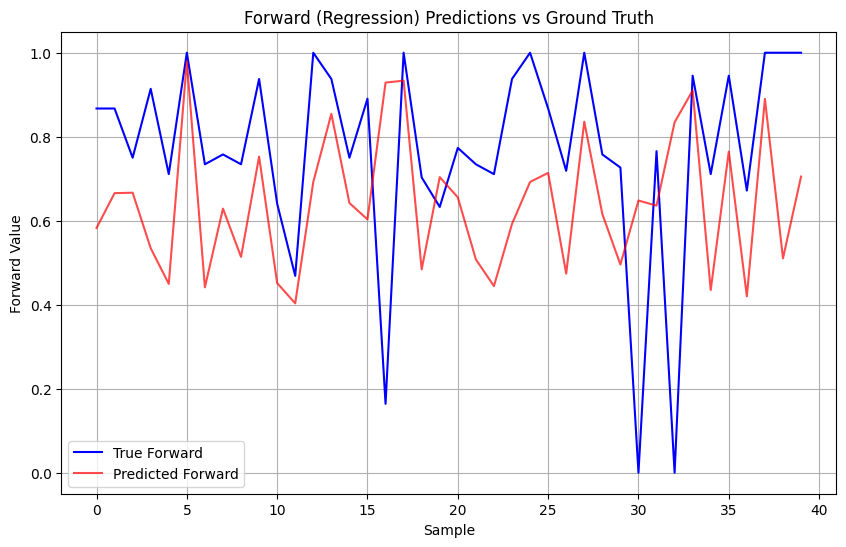

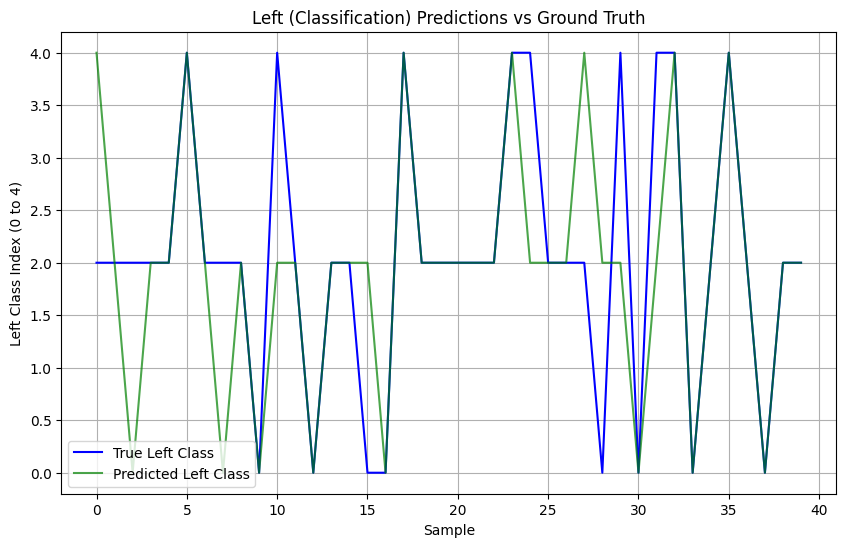

(0.7963064908981323, np.float32(0.24172488), np.float64(0.75))

In [18]:
# Evaluate the model
evaluate_model(model, test_loader, device)

## Exporting the model

In [19]:
model.eval()

import torch

# Assuming your model takes a (3, 224, 224) image as input
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

import torch.onnx

# Path where the ONNX model will be saved
onnx_model_path = "model_jetbot3.onnx"

# Exporting the model
torch.onnx.export(
    model,               # Model to export
    dummy_input,         # Example input tensor
    onnx_model_path,     # Path to save the ONNX file
    opset_version=11,    # Define the ONNX opset version
    input_names=["input"],       # Name of the input node
    output_names=["output"],     # Name of the output node
    dynamic_axes={
        "input": {0: "batch_size"},  # Dynamic batch size
        "output": {0: "batch_size"}  # Dynamic batch size
    },
    do_constant_folding=True,  # Enable constant folding optimization
    verbose=True              # Show detailed export info
)

import onnx

# Load the exported model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")



Model has been successfully exported to ONNX format!
